# Attempt to extract refractive index from time domain

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from Matrix_methods.Simulate import simulate_reference, simulate_parallel, c 
from Matrix_methods.TimeDomain_extractor import TimeDomainExtractor

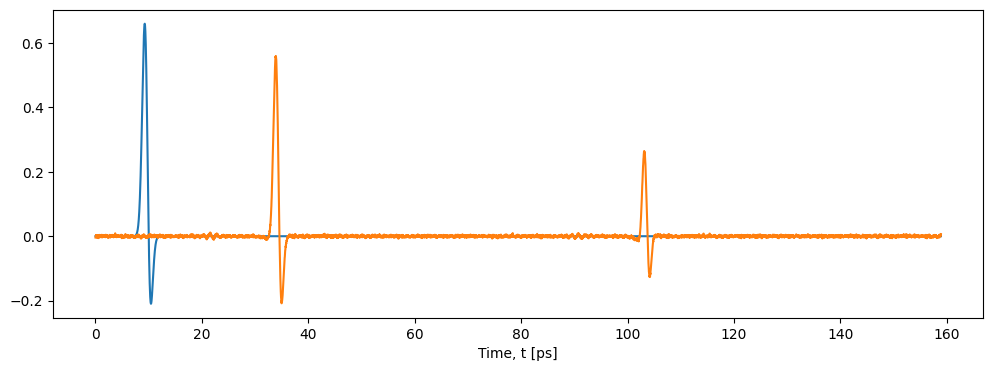

In [2]:
# Define simulation parameters
deltat = 0.0194e-12  # Time step
L = 2**13  # Number of time points

# Generate reference pulse
reference_pulse = simulate_reference(L, deltat)

# Experimental material parameters (ground truth)
material_params_exp = [(3.46+0.01j, 3 * 1e-3)]

# Simulate the experimental data
t_axis = np.arange(0, L * deltat, deltat)
_, experimental_pulse = simulate_parallel(reference_pulse, material_params_exp, deltat, noise_level=0.002)
experimental_pulse = experimental_pulse[:L]


plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse)
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy())
plt.xlabel('Time, t [ps]')
plt.show()

In [3]:
# Initial guesses
n_init, k_init, D_init = 3.40, 0.015, 2.7e-3

# Create and run the optimizer
extractor = TimeDomainExtractor(reference_pulse, experimental_pulse, deltat, n_init, k_init, D_init, lr=0.001)
optimized_n, optimized_k, optimized_D = extractor.optimize(num_iterations=150, updates=10, alpha=10)

initial_params = [(n_init + 1j*k_init, D_init)]
initial_pulse = simulate_parallel(reference_pulse, initial_params, deltat)[1][:L]

Optimizing for 150 with loss multiplier 10.
Iteration 0, Loss: 0.04395861178636551, n: 3.4010000228881836, k: 0.0139999995008111, D: 0.002699999837204814
Iteration 10, Loss: 0.034471265971660614, n: 3.4058940410614014, k: 0.0055221980437636375, D: 0.002699999837204814
Iteration 20, Loss: 0.03104015812277794, n: 3.4072265625, k: -0.0010817201109603047, D: 0.002699999837204814
Iteration 30, Loss: 0.02915232442319393, n: 3.407546043395996, k: -0.006374252028763294, D: 0.002699999837204814
Iteration 40, Loss: 0.027914434671401978, n: 3.407402992248535, k: -0.010785202495753765, D: 0.002699999837204814
Iteration 50, Loss: 0.02702285535633564, n: 3.4070236682891846, k: -0.014619442634284496, D: 0.002699999837204814
Iteration 60, Loss: 0.02633294090628624, n: 3.4064886569976807, k: -0.01806912198662758, D: 0.002699999837204814
Iteration 70, Loss: 0.025777583941817284, n: 3.405855655670166, k: -0.02124699205160141, D: 0.002699999837204814
Iteration 80, Loss: 0.025317702442407608, n: 3.40514707

[((3.399355411529541-0.0414147675037384j), 0.002699999837204814)]


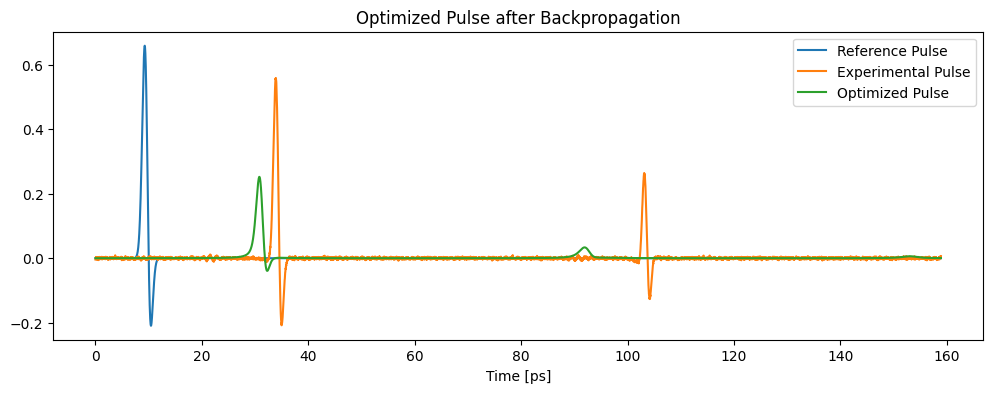

In [4]:
best_params = [(optimized_n + 1j*optimized_k, optimized_D)]
print(best_params)
best_pulse = simulate_parallel(reference_pulse, best_params, deltat)[1][:L]

# Plot results
plt.figure(figsize=(12, 4))
plt.plot(t_axis * 1e12, reference_pulse, label='Reference Pulse')
plt.plot(t_axis * 1e12, experimental_pulse.detach().cpu().numpy(), label='Experimental Pulse')
#plt.plot(t_axis * 1e12, initial_pulse.detach().cpu().numpy(), label='Initial Pulse')
plt.plot(t_axis * 1e12, best_pulse.detach().numpy(), label='Optimized Pulse')
plt.xlabel('Time [ps]')
plt.legend()
plt.title('Optimized Pulse after Backpropagation')
plt.show()

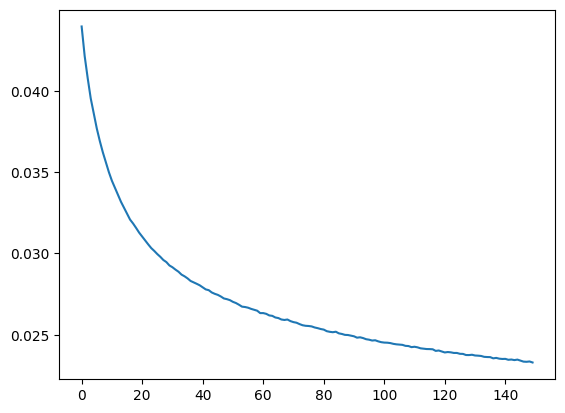

In [7]:
plt.plot(extractor.loss_history)
plt.show()

In [5]:
print(f'forward pass single run time: {extractor.forward_time}s')
print(f'backwards pass single run time: {extractor.backwards_time}s')
print(f'optimizer single run time: {extractor.optimizer_time}s')

forward pass single run time: 1.2657784589973744s
backwards pass single run time: 3.2123830830096267s
optimizer single run time: 0.0002119579876307398s


In [6]:
print(f'forward pass 100 iter run time: {extractor.forward_time * 100} s')
print(f'backwards pass 100 iter run time: {extractor.backwards_time * 100} s')
print(f'optimizer 100 iter run time: {extractor.optimizer_time * 100} s')

forward pass 100 iter run time: 126.57784589973744 s
backwards pass 100 iter run time: 321.2383083009627 s
optimizer 100 iter run time: 0.02119579876307398 s
